# Practical Bayesian Optimization

The purpose of this notebook is to demonstrate a few feature engineering techniques that use only latitude and longitude.

## 0. Env

#### Imports

In [18]:
import os
import time
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [2]:
pl.Config.set_fmt_str_lengths(90)

polars.config.Config

#### Constants

In [3]:
home = "../.."
images_dir = os.path.join(home, "static/images/")

In [4]:
TRAIN_TEST_SPLIT_FRACTION = 0.8
MODEL_TARGET = "price_log10"

## 1. Load Data

#### Load data for New York City

In [5]:
df_query = (
    pl.scan_csv("../data/miami-housing.csv")
    .with_columns([
        pl.col("SALE_PRC").alias("price"),
        pl.col(["LATITUDE", "LONGITUDE"]).name.to_lowercase()
    ])
    .select(pl.col(["latitude", "longitude", "price"]))
    .with_columns((pl.col("price")).log10().name.suffix("_log10"))
)

In [6]:
num_rows = df_query.collect().shape[0]
df = (
    df_query.collect()
    .sample(fraction=1, shuffle=True)
    .with_row_index(name="row_number")
    .with_columns([
        (pl.col("row_number") < TRAIN_TEST_SPLIT_FRACTION * num_rows).alias("is_train")
    ])
)

#### Viewing the data

In [7]:
display(df.count())

row_number,latitude,longitude,price,price_log10,is_train
u32,u32,u32,u32,u32,u32
13932,13932,13932,13932,13932,13932


In [8]:
display(
    df
    .head()
)

row_number,latitude,longitude,price,price_log10,is_train
u32,f64,f64,f64,f64,bool
0,25.758395,-80.221979,489000.0,5.689309,true
1,25.817729,-80.286506,370000.0,5.568202,true
2,25.466371,-80.497457,145000.0,5.161368,true
3,25.89537,-80.199682,151000.0,5.178977,true
4,25.669596,-80.419515,350500.0,5.544688,true


## 2. Brief EDA

#### Distribution of Prices

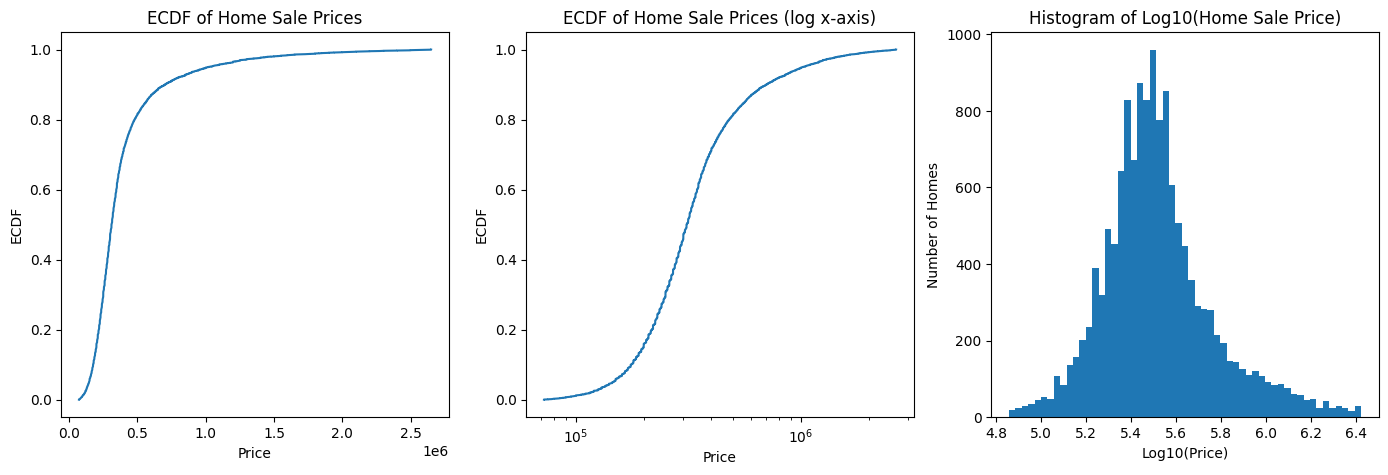

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))

ax1.plot(df["price"].sort(), np.linspace(0, 1, len(df)))
ax1.set_xlabel("Price")
ax1.set_ylabel("ECDF")
ax1.set_title("ECDF of Home Sale Prices")

ax2.plot(df["price"].sort(), np.linspace(0, 1, len(df)))
ax2.set_xscale("log")
ax2.set_xlabel("Price")
ax2.set_ylabel("ECDF")
ax2.set_title("ECDF of Home Sale Prices (log x-axis)")

ax3.hist(df["price_log10"], bins=55, density=False)
ax3.set_xlabel("Log10(Price)")
ax3.set_ylabel("Number of Homes")
ax3.set_title("Histogram of Log10(Home Sale Price)")

plt.savefig(os.path.join(images_dir, "distribution-of-home-sale-price.png"))

#### Distribution over Space

In [10]:
df.select(["latitude", "longitude", "price"]).corr()

latitude,longitude,price
f64,f64,f64
1.0,0.721232,0.047701
0.721232,1.0,0.195274
0.047701,0.195274,1.0


## 3. Hyperparameter Optimization

### 3.0 Setup

In [11]:
X_train = df.filter(pl.col("is_train"))
y_train = df.filter(pl.col("is_train"))
X_test = df.filter(~pl.col("is_train"))
y_test = df.filter(~pl.col("is_train"))

In [13]:
MODEL_FEATURE_LIST_NAME = "raw_lat_lon"
MODEL_FEATURE_LIST = ["latitude", "longitude"]

### 3.1. Bayes Optimization

In [60]:
def plot_prediction_surface(grid, y_mean, y_std, duration_mean, acquisition_function):
    plt.plot(grid, y_mean, "r", label="Expected Value of Model Performance")
    plt.fill_between(grid.reshape(-1), y_mean - y_std, y_mean + y_std, alpha=0.1, color="black", label="± 1 std dev")
    plt.plot(grid, duration_mean, "orange", label="Expected Duration of Model Evaluation")
    plt.plot(grid, acquisition_function, "black", label="Acquisition Function")
    plt.xlabel("n_estimators")
    plt.legend()
    plt.show()

100 0.8876 0.0596


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 5. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 5. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


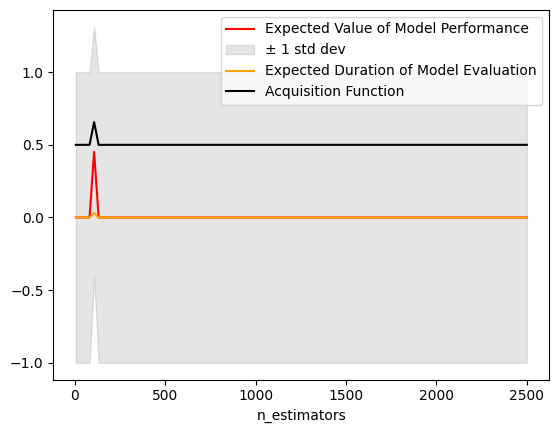

105 0.8877 0.0538


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 2500. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


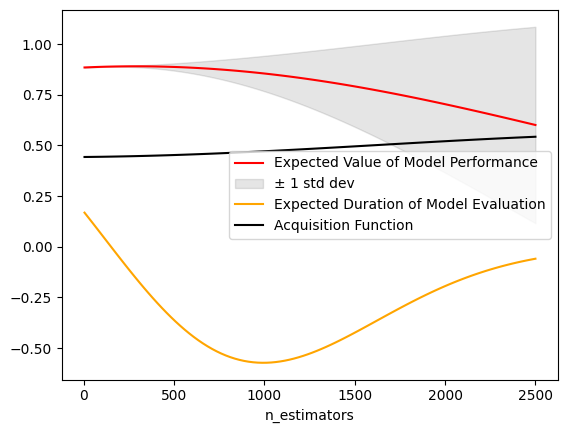

2500 0.8905 0.9510


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 2500. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


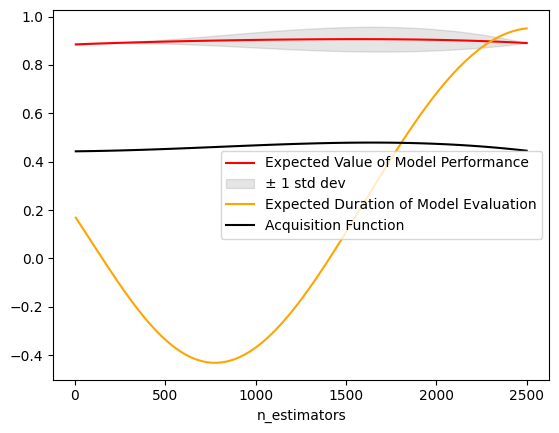

1643 0.8915 0.6287


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 2500. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


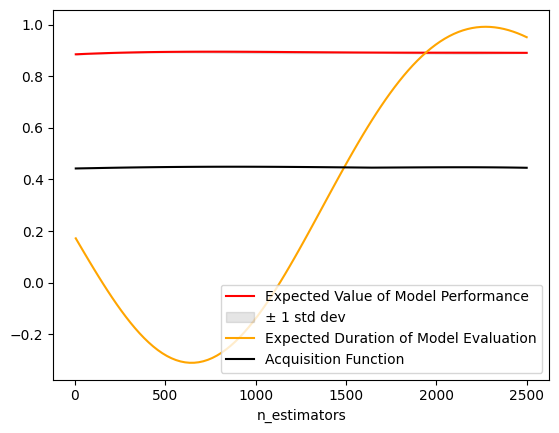

887 0.8927 0.3517


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 2500. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


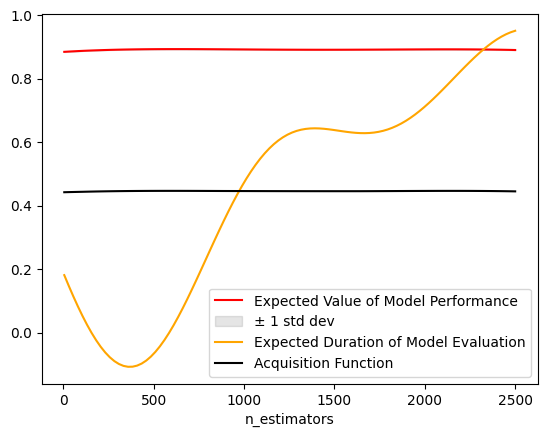

584 0.8928 0.2234


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 2500. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


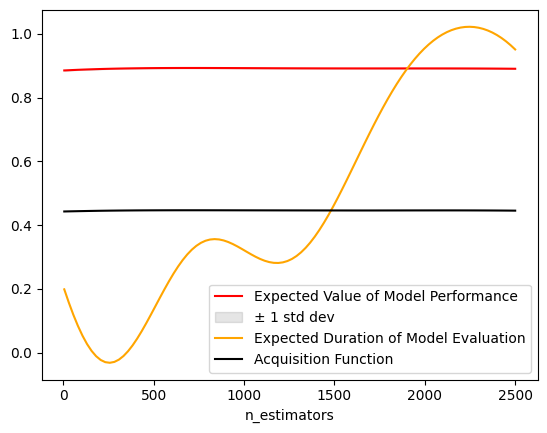

710 0.8929 0.2772


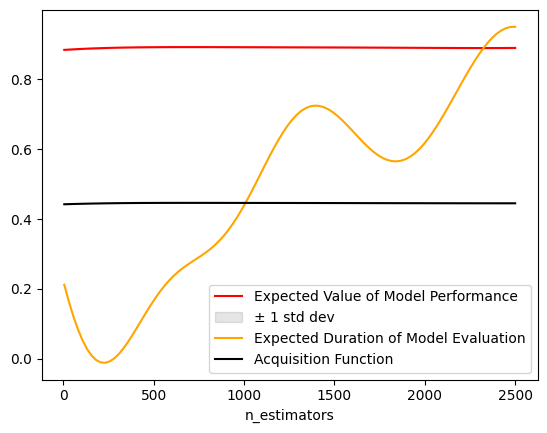

685 0.8929 0.2618


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


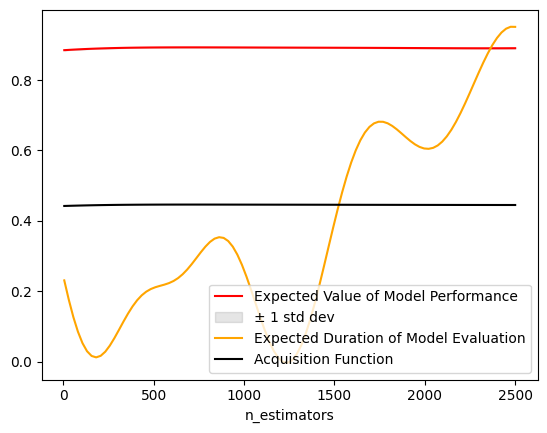

685 0.8929 0.2752


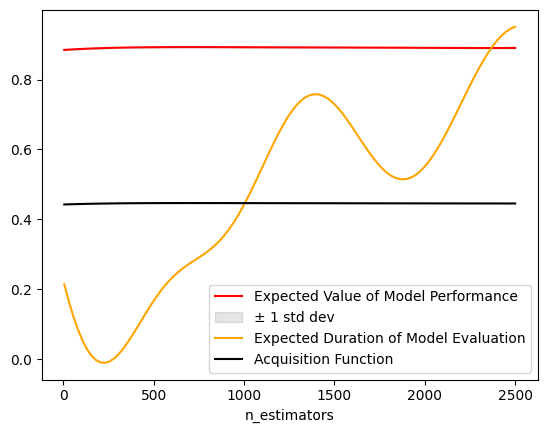

685 0.8929 0.2603


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


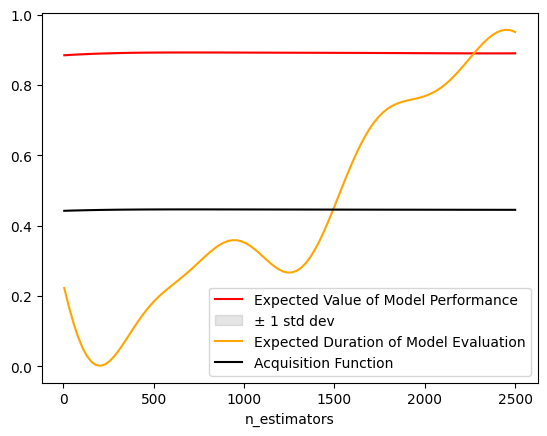

685 0.8929 0.2715


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


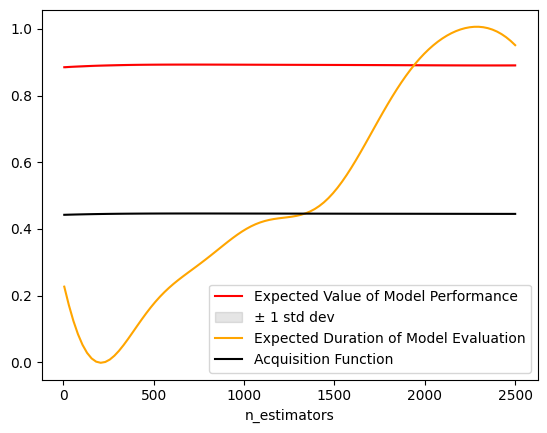

710 0.8929 0.2923


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


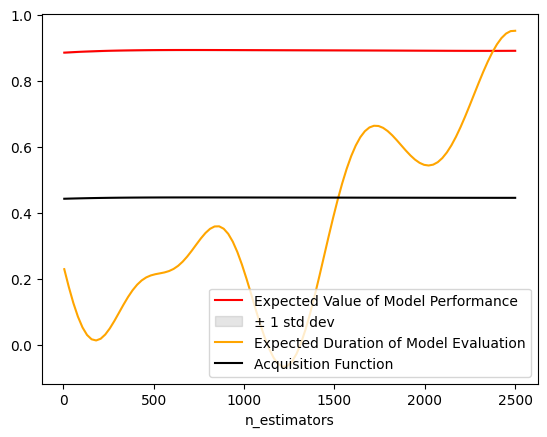

685 0.8929 0.2805


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


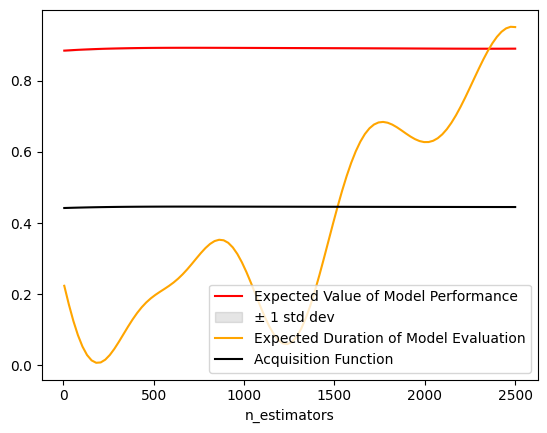

685 0.8929 0.2684


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


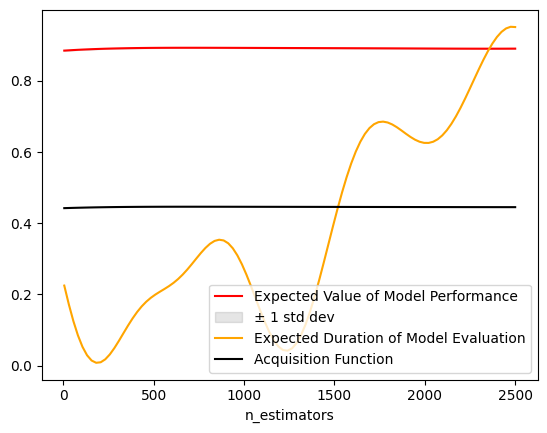

685 0.8929 0.2731


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


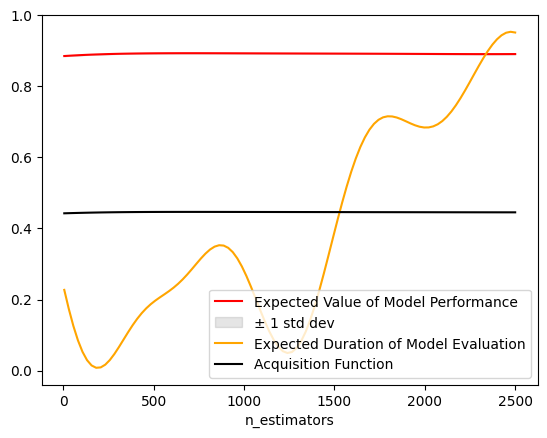

685 0.8929 0.2853


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


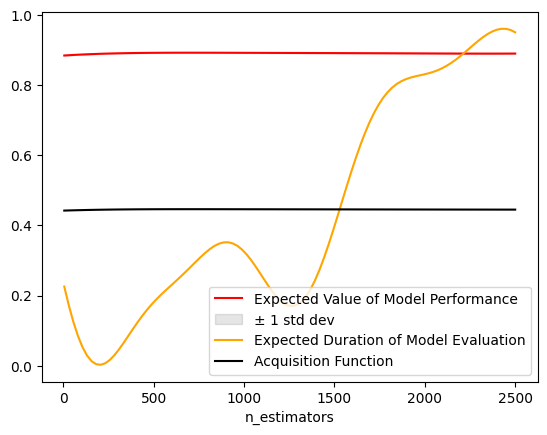

685 0.8929 0.2674


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


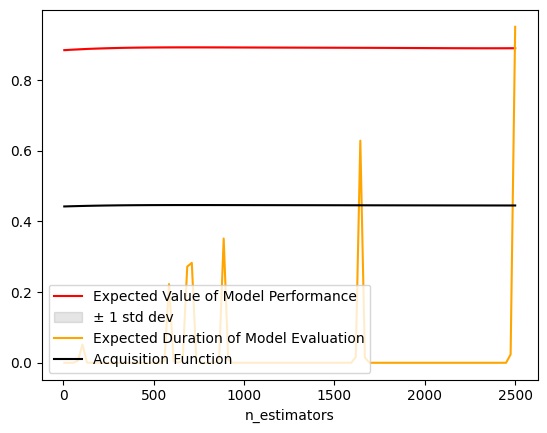

685 0.8929 0.2863


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


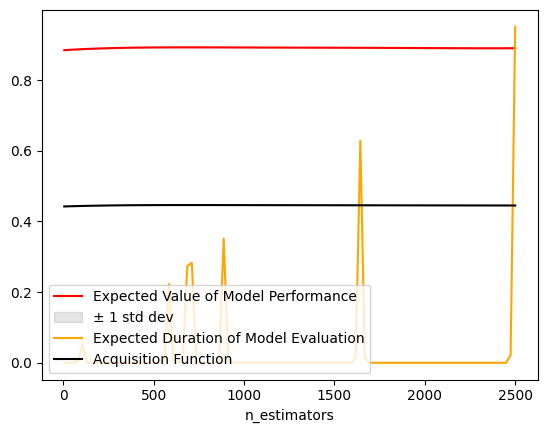

685 0.8929 0.2902


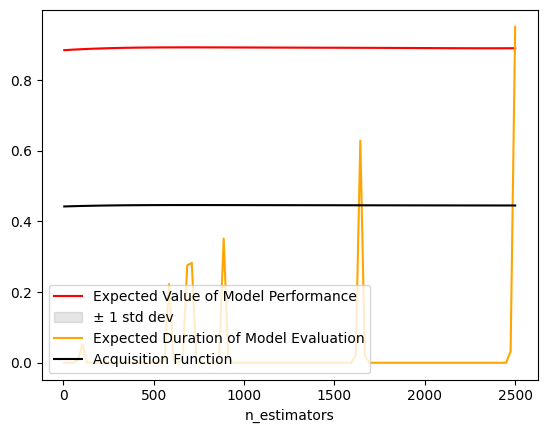

685 0.8929 0.2706


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


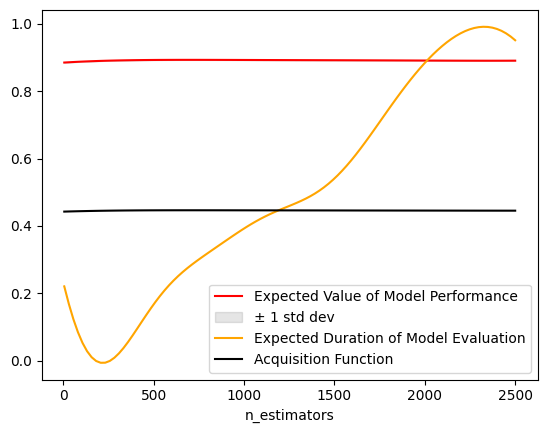

685 0.8929 0.2879


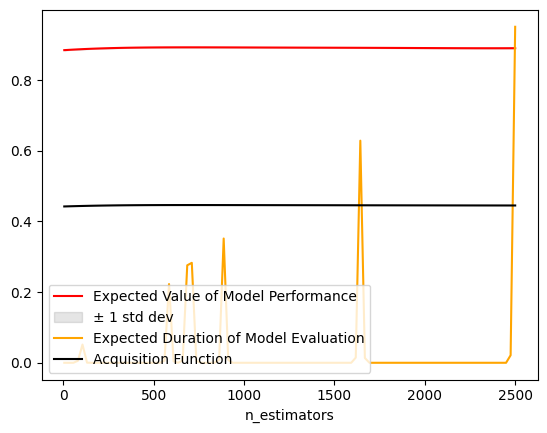

685 0.8929 0.2831


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


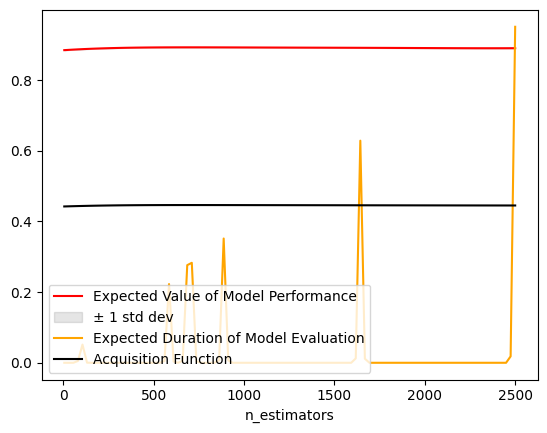

685 0.8929 0.2864


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


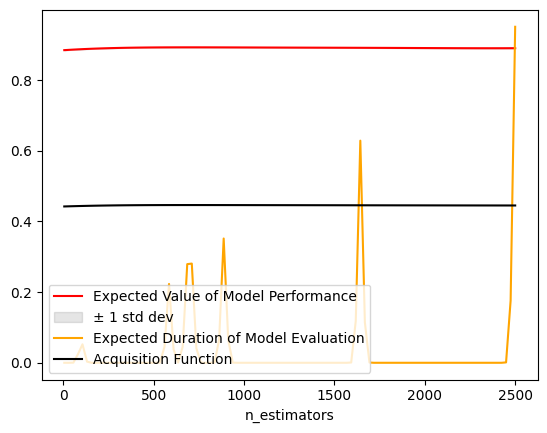

685 0.8929 0.2860


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


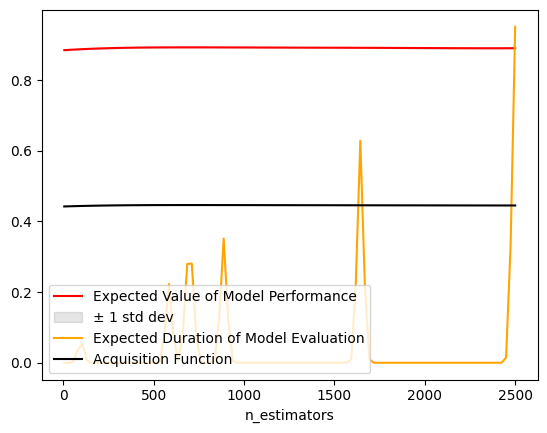

685 0.8929 0.2878


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


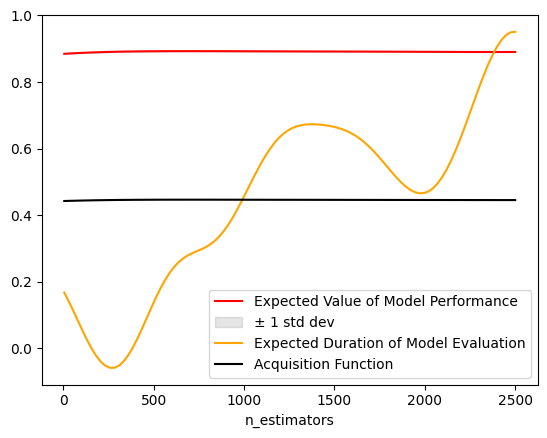

685 0.8929 0.2825


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


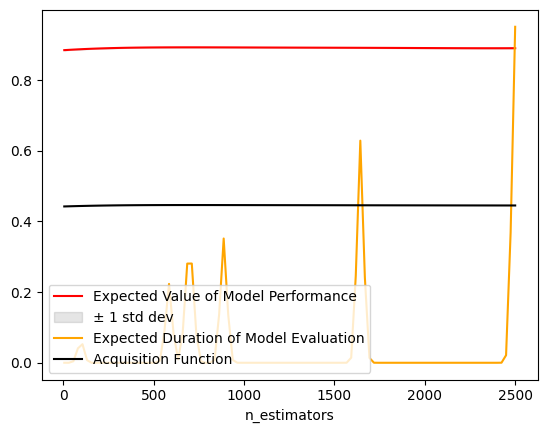

685 0.8929 0.2962


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


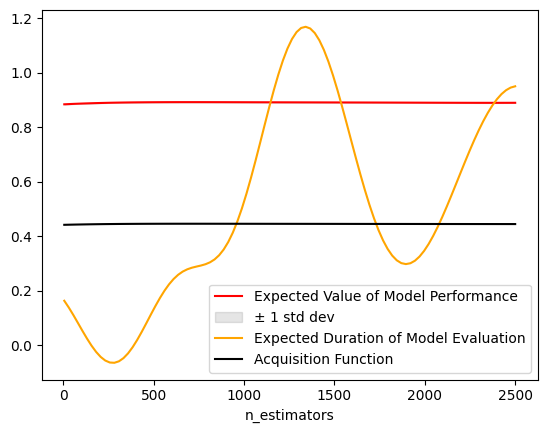

685 0.8929 0.2702


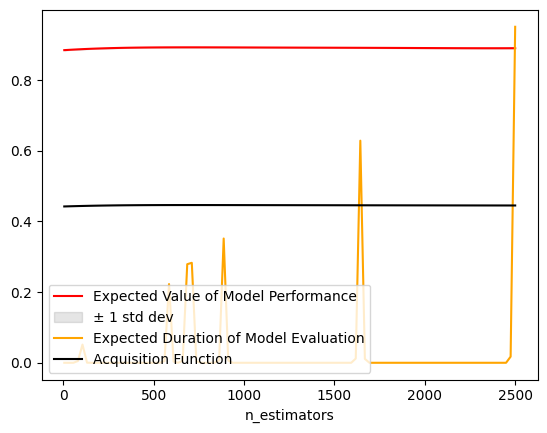

685 0.8929 0.2710


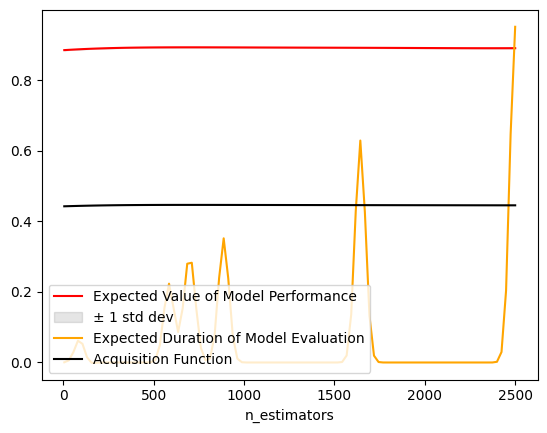

685 0.8929 0.2737


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


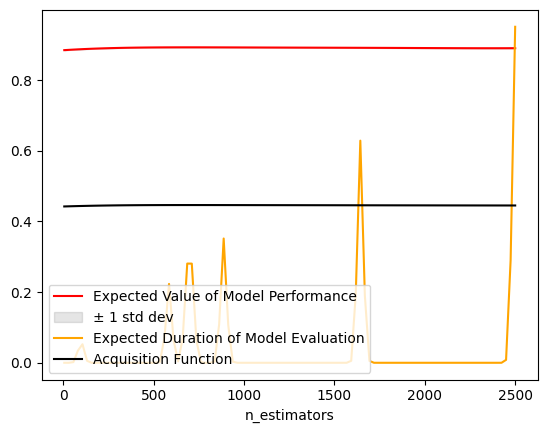

685 0.8929 0.2899


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


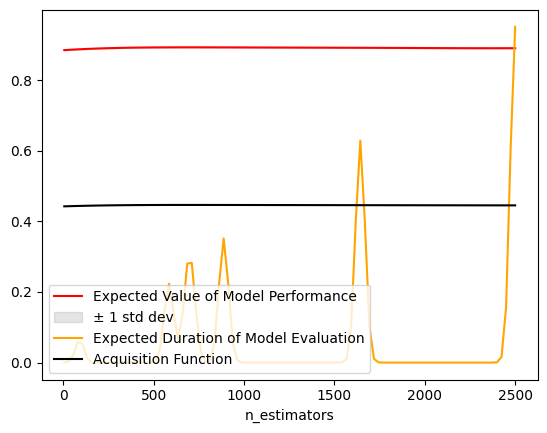

685 0.8929 0.2866


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


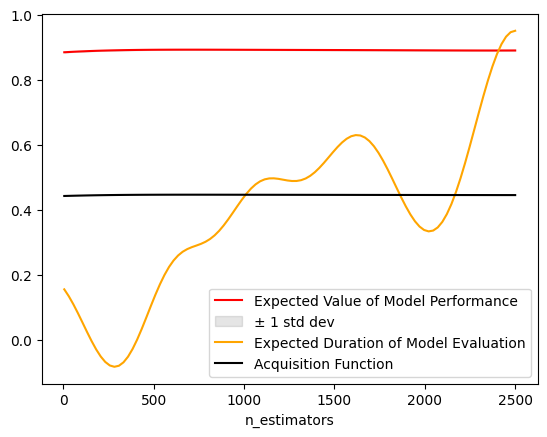

685 0.8929 0.2693


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


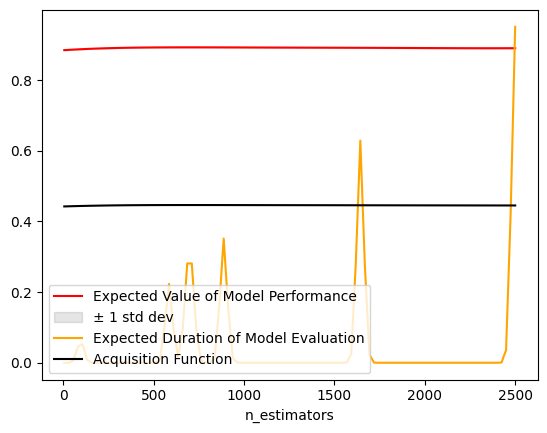

685 0.8929 0.2732


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


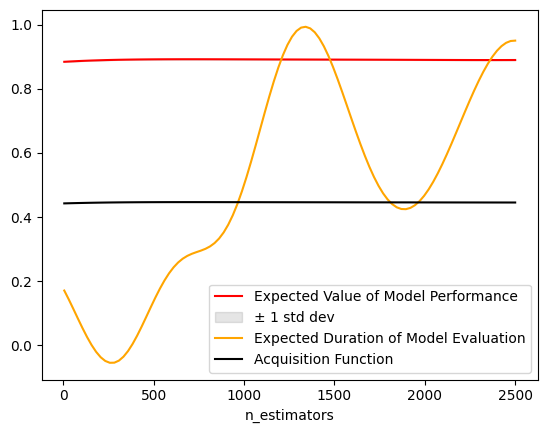

685 0.8929 0.2813


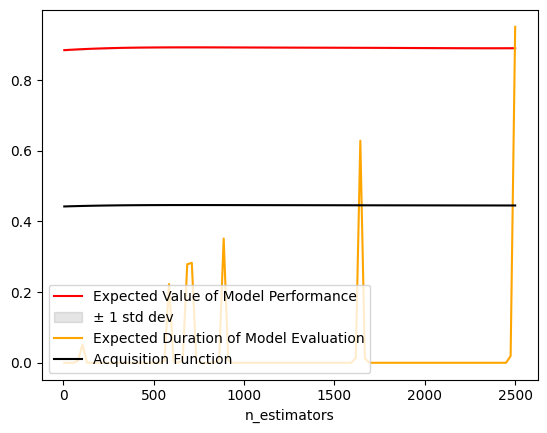

685 0.8929 0.2684


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


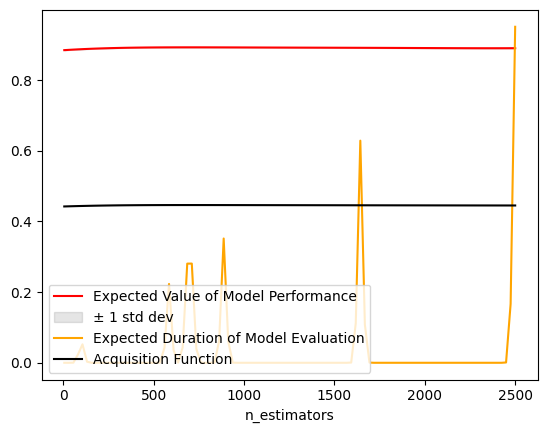

685 0.8929 0.2710


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


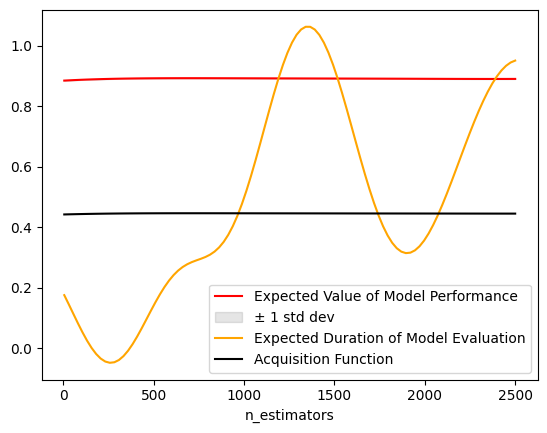

685 0.8929 0.2942


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


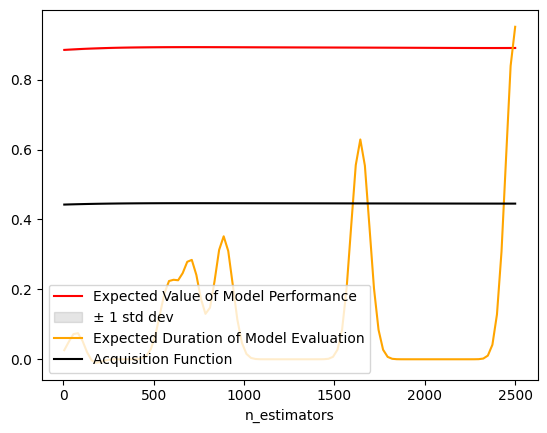

685 0.8929 0.2961


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


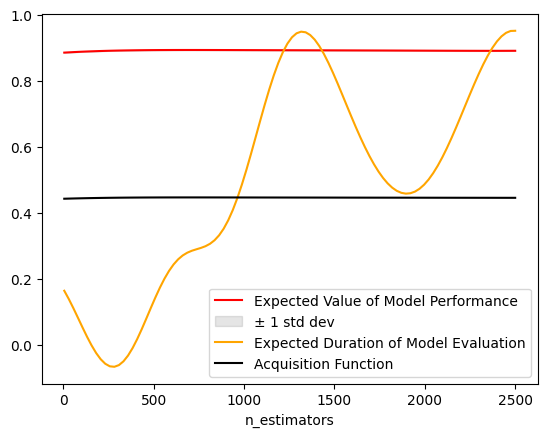

685 0.8929 0.2815


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


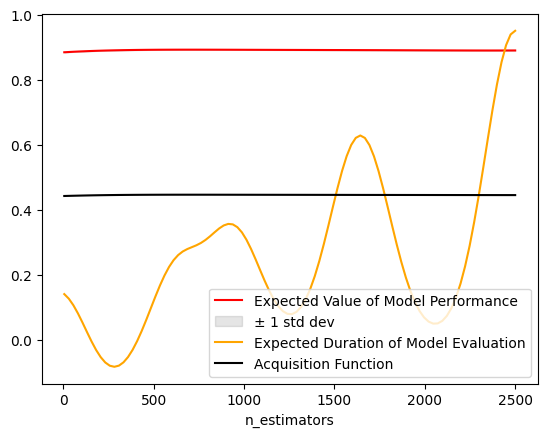

685 0.8929 0.2791


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


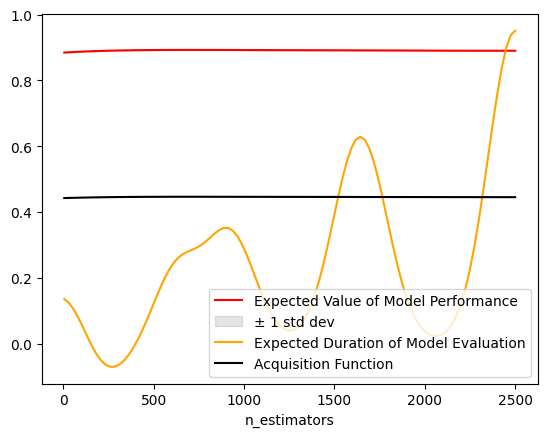

685 0.8929 0.2876


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the 

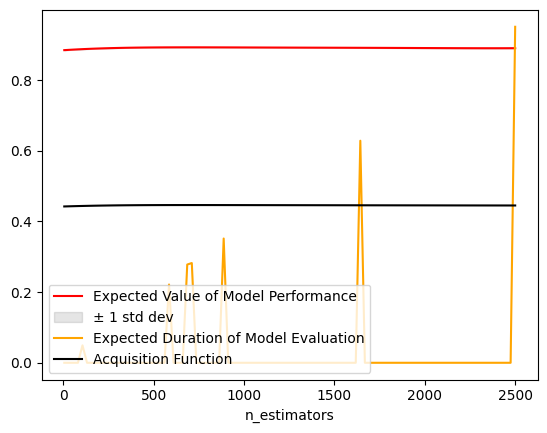

685 0.8929 0.2893


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


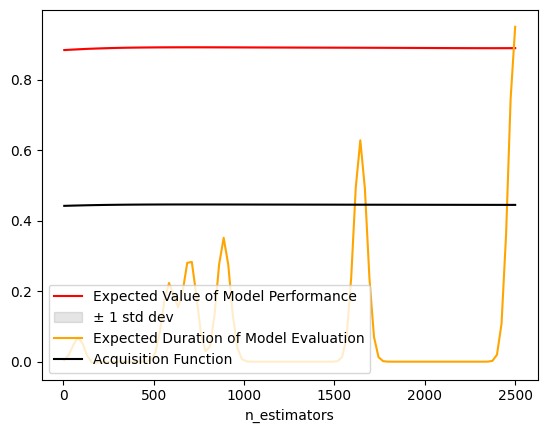

685 0.8929 0.3184


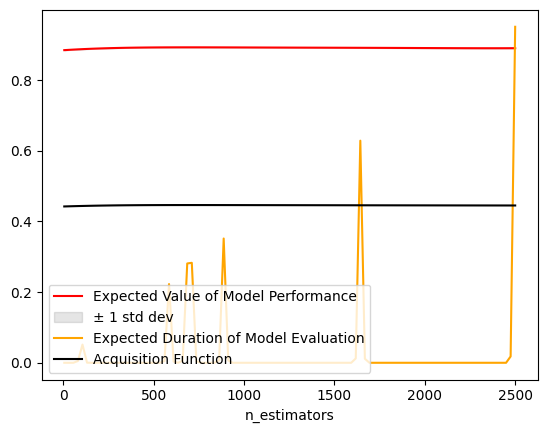

685 0.8929 0.2962


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


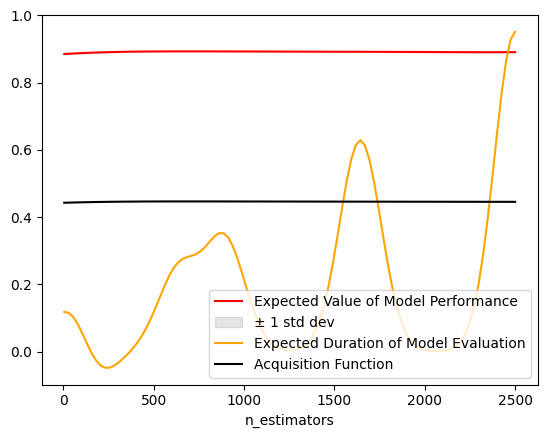

685 0.8929 0.2817


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


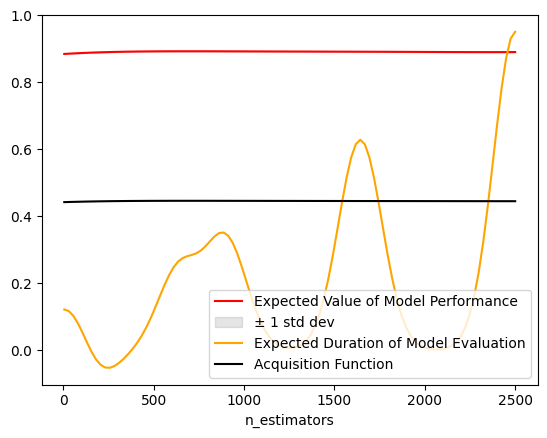

685 0.8929 0.2964


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


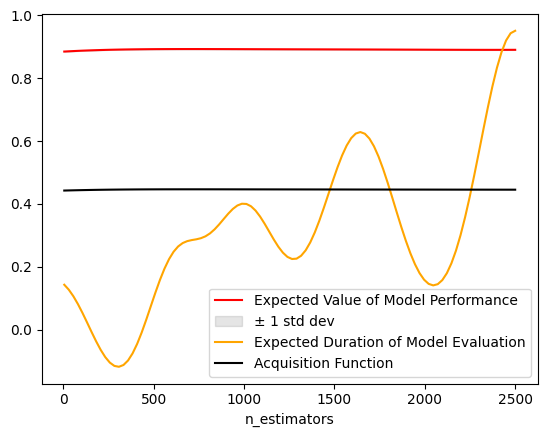

685 0.8929 0.3019


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


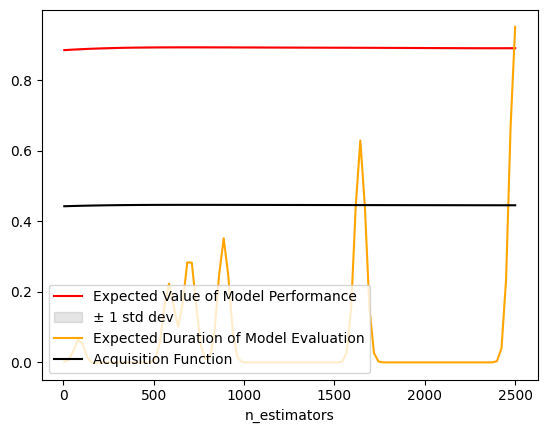

685 0.8929 0.3016


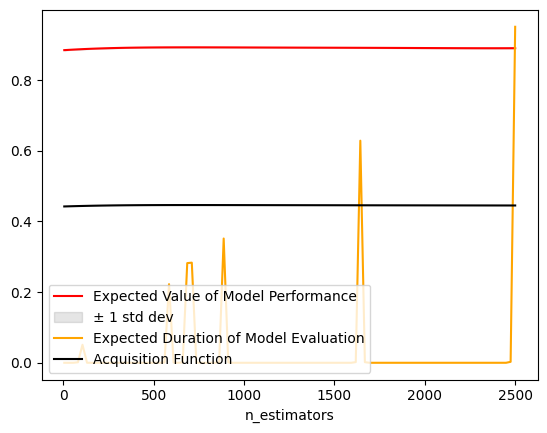

685 0.8929 0.2739


/Users/benfeifke/code/personal-website/code/.venv/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [61]:
n_estimators_hp_range = (5, 2500)
grid_resolution = 100
n_estimators_grid = np.linspace(*n_estimators_hp_range, grid_resolution).reshape(-1, 1)

n_estimators_init = 100
n_estimators_attempts = []
n_estimators_performances = []
durations = []

kernel = RBF(length_scale=2.0, length_scale_bounds=n_estimators_hp_range)
performance_bayesian_optimizer = GaussianProcessRegressor(kernel=kernel)
duration_bayesian_optimizer = GaussianProcessRegressor(kernel=kernel)
explore_exploit = .5

for run_number in range(50):

    # init_case
    if run_number == 0:
        n_estimators = n_estimators_init
    else:
        grid_predicted_mean, grid_predicted_std = performance_bayesian_optimizer.predict(n_estimators_grid, return_std=True)
        duration_predicted_mean = duration_bayesian_optimizer.predict(n_estimators_grid)
        acquisition_function = explore_exploit * grid_predicted_mean + (1 - explore_exploit) * grid_predicted_std
        next_best_n_estimators = n_estimators_grid[acquisition_function.argmax()]
        n_estimators = int(next_best_n_estimators)
        plot_prediction_surface(
            n_estimators_grid,
            grid_predicted_mean,
            grid_predicted_std,
            duration_predicted_mean,
            acquisition_function,
        )
    
    # predict
    t_start = time.time()
    model = (
        LGBMRegressor(
            n_estimators=n_estimators,
            force_col_wise=True,
            verbosity=0,
        )
        .fit(
            X_train.select(MODEL_FEATURE_LIST),
            y_train.select(MODEL_TARGET).to_series()
        )
    )
    y_predicted = model.predict(X_test.select(MODEL_FEATURE_LIST))
    model_performance = 1 - root_mean_squared_error(y_test.select(MODEL_TARGET).to_series(), y_predicted)
    t_end = time.time()
    duration = t_end - t_start
    print(n_estimators, f"{model_performance:.04f}", f"{duration:.04f}")
    
    # fit bayesian optimizer
    n_estimators_attempts.append([n_estimators])
    n_estimators_performances.append(model_performance)
    durations.append(duration)
    performance_bayesian_optimizer.fit(n_estimators_attempts, n_estimators_performances)
    duration_bayesian_optimizer.fit(n_estimators_attempts, durations)